In this notebook, we first used a parallel environment to perform a parameter sweep to determine the most optimal regularization parameters. These are the alpha and l1_ratio parameters. To select parameters, we took the alpha and l1_ratio that maximized the average correlation in 4-fold cross-validation (to the hundreds) and minimized the average root mean squared error between the predictions and the actual ages. The four-fold was done in such a way that days were grouped so that older ages would appear in each fold. This was looped for an input of alpha and l1_ratios, where each fold of cross validation was saved. This can be found in 'scripts/CV_ElasticNet_Training_stratifiedKfold_stratname_general_loopRegParams.py'. It takes as input, a file indicating which alpha and l1_ratio to test in that iteration. This is provided as a tab-delimited file where alpha is the first column and l1_ratio is the second column. Other inputs include: the directory to write out results, the input hdffile (indexed by methy_mat for methyation values and covariates for covariates), the selection of markers (generally set to all), the variable to learn, if the columns are integers (generally True), and the stratified variable name. 

### Notebook Imports

In [1]:
from __future__ import division
import os
import numpy as np
import random 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline
import itertools

import imp
twto = imp.load_source('twto','scripts/twang_toolbox.py')
meth = imp.load_source('meth','scripts/methy_parsing.py')

from sklearn import cross_validation, linear_model, metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats as smstats
import scipy.stats as stats
import scipy.cluster.hierarchy as hac

In [2]:
#Used for paper
sns.set(context = "paper", style='ticks',rc={"font.size":8,"legend.fontsize":5,"axes.titlesize":8,
                             "axes.labelsize":6,"xtick.labelsize":6,"ytick.labelsize":6, 'xtick.major.size': 3.0,
 'xtick.minor.size': 1.0,'ytick.major.size': 3.0,
 'ytick.minor.size': 1.0})

### Functions used

In [3]:
def apply_model(mod_obj,df):
    predictions = mod_obj.predict(df)
    return pd.Series([2**x for x in predictions],index=df.index,name='EpiAgeMonths')/30.42
def make_lmreg(x,y):
    lm = linear_model.LinearRegression()
    lm = lm.fit(pd.DataFrame(x),y)
    return(lm.coef_[0],lm.intercept_)

In [4]:
def format_predictions_df(predictions_df):
    predictions_df = predictions_df.copy(deep=True)
    predictions_df['Age_month'] = (predictions_df['age_daysnotlog']/30.42).round(1)
    map_treatment = {'D':'D', 'Rapa':'Rapa', 'CR':'CR', 'normal':'untreated', 'high/high':'untreated', 'high/low':'untreated', 'low/high':'untreated'}
    predictions_df['treatment2'] = predictions_df['treatment'].map(map_treatment)
    predictions_df['Epi-actual'] = predictions_df['EpiAgeMonths'] -predictions_df['Age_month']
    #f,axes = plt.subplots(2,2,figsize=(10,8))
    map_control_treatment_strains = {'Ames':{2:{'D':'2m Ames dwarf','untreated':'2m Ames'},22:{'D':'22m Ames dwarf','untreated':'22m Ames'}},
                                 'Miller':{2:{'untreated':'2m UMHET3'},22:{'untreated':'22m UMHET3','Rapa':'22m UMHET3 Rapa','CR':'22m UMHET3 CR'}},'SRP032932':{'untreated':'2.1m C57BL6'}}
    for k,grp in predictions_df.groupby('Study'):
        if k !='SRP032932':
            for k2,grp2 in grp.groupby('Age_month'):
                study_map_mouse = map_control_treatment_strains[k][k2]
                predictions_df.loc[grp2.index,'mouse'] = predictions_df.loc[grp2.index,'treatment2'].map(study_map_mouse)
        else:
            study_map_mouse = map_control_treatment_strains[k]
            predictions_df.loc[grp.index,'mouse'] = predictions_df.loc[grp.index,'treatment2'].map(study_map_mouse)
    predictions_df['treatment'] = predictions_df['treatment'].map({'normal':'untreated','high/high':'high/high','high/low':'high/low','low/high':'low/high','D':'D','Rapa':'Rapa','CR':'CR'})
    predictions_df['ChronAgeMonth'] = predictions_df['Age_month'].round(1)
    controls = predictions_df[predictions_df['treatment2']=='untreated']
    m_controls,b_controls = make_lmreg(controls.loc[controls.mouse!='2.1m C57BL6','Age_month'],controls.loc[controls.mouse!='2.1m C57BL6','EpiAgeMonths'])
    predictions_df['RescaledEpiAges'] = (predictions_df['EpiAgeMonths']-b_controls)/m_controls
    predictions_df['RescaledEpi-Actual'] = predictions_df['RescaledEpiAges']-predictions_df['Age_month']
    return(predictions_df)

#### Plotting functions

In [5]:
def make_cv_figplot_log(cv_resultstt,axes,legend_loc,markersize=30,range_end_treat=20):
    #colors = sns.color_palette("Set2", 5).as_hex()
    #min_predictions = predictions_df['EpiAgeMonths'].min()
    ax=axes
    j=0
    nonneg_cv_results = cv_resultstt.loc[cv_resultstt.predicted>0]
    ax.plot(np.log2(np.linspace(0.001,28,100)),np.log2(np.linspace(0.001,28,100)),'--',color='gray')
    #for k,grp in nonneg_cv_results.groupby('fold'):
    ax.scatter(np.log2(nonneg_cv_results['actual']),np.log2(nonneg_cv_results['predicted']),color='black',s=markersize,alpha=0.3)
    #    j=j+1
    m_cv,b_cv = make_lmreg(np.log2(nonneg_cv_results['actual']/30.42),np.log2(nonneg_cv_results['predicted']))
    #ax.plot(np.linspace(0.001,28,100),[m_cv*x+b_cv for x in np.linspace(0.001,28,100)],label='cv:y = {}x{}{}'.format(round(m_cv,2),['+',''][b_cv<0],round(b_cv,1)))
    ax.set_xlim([-2,np.log2(range_end_treat)])
    ax.set_ylim([-2,np.log2(range_end_treat)])
    ax.set_xticklabels([round(2**x,1) for x in ax.get_xticks()])
    ax.set_yticklabels([round(2**x,1) for x in ax.get_yticks()])
    #handles,labels = ax.get_legend_handles_labels()
    corr_per_fold = [grp['predicted'].corr(grp['actual']) for k,grp in nonneg_cv_results.groupby('fold')]
    #ax.legend(handles,['{0}fold; r = {1:.2f}'.format(labels[i],round(corr_per_fold[i],2)) for i in range(len(corr_per_fold))],
    #           bbox_to_anchor=legend_loc,frameon=True,markerscale=.5,ncol=2,labelspacing=0.1,handletextpad=0.1)
    ax.annotate('r = {0:.2f}'.format(round(np.mean(corr_per_fold),2)),xy=(np.log2(0.5),np.log2(10)))
    ax.set_ylabel('Epigenetic age in months',fontsize=8)
    ax.set_xlabel('Chronological age in months',fontsize=8)
    sns.despine()
    #return(predictions_df)

def make_test_plot(predictions_df,axes,legend_loc,range_end_treat=28,offset_ages_amt=0.3,markersize=30):
    ax=axes
    controls = predictions_df[predictions_df['treatment2']=='untreated']
    min_predictions = predictions_df['EpiAgeMonths'].min()
    m_controls,b_controls = make_lmreg(controls['Age_month'],controls['EpiAgeMonths'])
    map_study = {'Ames':'Ames','Miller':'UMHET3','SRP032932':'C57BL6'}
    color_xkcd_pal_dict = {'Ames':sns.xkcd_rgb["ocean blue"],'Miller':sns.xkcd_rgb["greenish blue"],'SRP032932':sns.xkcd_rgb["dark grey"]}
    markers_dict = {'Ames':'o','Miller':'D','SRP032932':'x'}
    offset_ages = offset_ages_amt
    #m_cv,b_cv = make_lmreg(cv_resultstt['actual']/30.42,cv_resultstt['predicted'])
    for k,grp in controls.groupby('Study'):
        marker = markers_dict[k]
        c = color_xkcd_pal_dict[k]
        ax.scatter(grp['Age_month']+offset_ages,grp['EpiAgeMonths'],marker=marker,color=c,label=map_study[k],s=markersize,alpha=0.7)
        offset_ages = offset_ages+offset_ages_amt
    ax.plot(range(-10,28),range(-10,28),'--',color='gray')
    #ax.plot(range(-10,28),[m_controls*x+b_controls for x in range(-10,28)],color='black',label='untreated')
            #label='untreated:y = {}x{}{}'.format(round(m_controls,1),['+',''][b_controls<0],round(b_controls,1)))
    #ax.legend(ncol=2,frameon=True,bbox_to_anchor=(1,-0.15))
    ax.legend(ncol=2,frameon=True,bbox_to_anchor = legend_loc,markerscale=0.7)
    if min_predictions<-1:
        ax.set_ylim(min_predictions-1,range_end_treat)
        ax.set_xlim([min_predictions-1,range_end_treat])
    else:
        ax.set_ylim([-5,range_end_treat])
        ax.set_xlim([-5,range_end_treat])
    ax.set_ylabel('Epigenetic age in months',fontsize=8)
    ax.set_xlabel('Chronological age in months',fontsize=8)
    sns.despine()

def make_interventions_plot(predictions_df,axes,legend_loc,offset_ages_amt=0.3,markersize=30,swarmsize=5,range_end_treat=2,rescale=False):
    #C
    ax=axes
    controls = predictions_df[(predictions_df['treatment2']=='untreated') & (predictions_df['mouse']!='2.1m C57BL6')]
    min_predictions = predictions_df['EpiAgeMonths'].min()
    m_controls,b_controls = make_lmreg(controls['Age_month'],controls['EpiAgeMonths'])
    predictions_df['RescaledEpiAges'] = (predictions_df['EpiAgeMonths']-b_controls)/m_controls
    min_predictions_rescaled = predictions_df['RescaledEpiAges'].min()
    notcontrols = predictions_df[predictions_df['treatment2']!='untreated']
    m_controls_rescaled,b_controls_rescaled = make_lmreg(predictions_df.loc[controls.index,'Age_month'],predictions_df.loc[controls.index,'RescaledEpiAges'])
    m_notcontrols,b_notcontrols = make_lmreg(notcontrols['Age_month'],notcontrols['EpiAgeMonths'])
    m_notcontrols_rescaled,b_notcontrols_rescaled = make_lmreg(notcontrols['Age_month'],notcontrols['RescaledEpiAges'])
    map_study_treatment_dict = {'D':'Ames dwarf','Rapa':'UMHET3 Rapa','CR':'UMHET3 CR'}
    map_study = {'Ames':'Ames','Miller':'UMHET3','SRP032932':'C57BL6'}
    adams_xkcd_pal_dict = {'D':sns.xkcd_rgb["baby blue"],'Rapa':sns.xkcd_rgb["hunter green"],'CR':sns.xkcd_rgb["greenish grey"]}
    markers_dict_treat = {'D':'H','Rapa':'d','CR':'s'}
    markers_dict = {'Ames':'o','Miller':'D','SRP032932':'x'}
    color_xkcd_pal_dict = {'Ames':sns.xkcd_rgb["ocean blue"],'Miller':sns.xkcd_rgb["greenish blue"],'SRP032932':sns.xkcd_rgb["dark grey"]}
    offset_ages = offset_ages_amt
    for k,grp in notcontrols.groupby('treatment'):
        color = adams_xkcd_pal_dict[k]
        marker=markers_dict_treat[k]
        if not rescale:
            ax.scatter(grp['Age_month']+offset_ages,grp['EpiAgeMonths'],marker=marker,color=color,label=map_study_treatment_dict[k],s=markersize,alpha=0.7)
        else:
            ax.scatter(grp['Age_month']+offset_ages,grp['RescaledEpiAges'],marker=marker,color=color,label=map_study_treatment_dict[k],s=markersize,alpha=0.7)
        offset_ages = offset_ages+offset_ages_amt
    offset_ages = offset_ages_amt
    for k,grp in controls.groupby('Study'):
        marker = markers_dict[k]
        c = color_xkcd_pal_dict[k]
        if not rescale:
            ax.scatter(grp['Age_month']+offset_ages,grp['EpiAgeMonths'],marker=marker,color='gray',label=map_study[k],s=markersize,alpha=0.3)
        else:
            ax.scatter(grp['Age_month']+offset_ages,grp['RescaledEpiAges'],marker=marker,color='gray',label=map_study[k],s=markersize,alpha=0.3)
        offset_ages = offset_ages+offset_ages_amt
    if not rescale:
        ax.plot(range(-10,28),[m_controls*x+b_controls for x in range(-10,28)],color='black',label='untreated')
    else:
        ax.plot(range(-10,28),[m_controls_rescaled*x+b_controls_rescaled for x in range(-10,28)],color='black',label='untreated')
            #label='untreated:y = {}x{}{}'.format(round(m_controls,1),['+',''][b_controls<0],round(b_controls,1)))
    if not rescale:
        ax.plot(range(-10,28),[m_notcontrols*x+b_notcontrols for x in range(-10,28)],color='green',label='treated')
    else:
        ax.plot(range(-10,28),[m_notcontrols_rescaled*x+b_notcontrols_rescaled for x in range(-10,28)],color='green',label='treated')
            #label='treated:y = {}x{}{}'.format(round(m_notcontrols,1),['+',''][b_notcontrols<0],round(b_notcontrols,1)))
    ax.legend(ncol=2,frameon=True,bbox_to_anchor=legend_loc,markerscale=0.7)
    #ax.legend(ncol=3,frameon=True,loc='lower left')
    ax.set_xlim([-1,28])
    if not rescale:
        if min_predictions<-1:
            ax.set_ylim(min_predictions-1,range_end_treat)
            ax.set_xlim(min_predictions-1,range_end_treat)
        else:
            ax.set_ylim([-5,range_end_treat])
            ax.set_xlim([-5,range_end_treat])
    else:
        if min_predictions_rescaled<-1:
            ax.set_ylim(min_predictions_rescaled-1,range_end_treat)
            ax.set_xlim(min_predictions_rescaled-1,range_end_treat)
        else:
            ax.set_ylim([-5,range_end_treat])
            ax.set_xlim([-5,range_end_treat])
    ax.set_ylabel('Epigenetic age in months',fontsize=8)
    ax.set_xlabel('Chronological age in months',fontsize=8)
    ax.plot([-1, 1], [-1, 1], '--',transform=ax.transAxes,color='gray')
    sns.despine(ax=ax)

def make_residuals_plot(predictions_df,treat_col,color_pal,legend_loc,axes,hue_order,swarmsize=5,split=False,despine_bottom=True,hue_col='mouse',n_col=2,order=None,rescaled=False):
    #color_pal = sns.color_palette('pastel')
    if order:
        if not rescaled:
            ax = sns.swarmplot(x=predictions_df[treat_col],y=predictions_df['Epi-actual'],hue=predictions_df[hue_col],order=order,palette=color_pal,s=swarmsize,split=split,hue_order=hue_order,alpha=0.7,ax=axes)
        else:
            ax = sns.swarmplot(x=predictions_df[treat_col],y=predictions_df['RescaledEpi-Actual'],hue=predictions_df[hue_col],order=order,palette=color_pal,s=swarmsize,split=split,hue_order=hue_order,alpha=0.7,ax=axes)
    else:
        if not rescaled:
            ax = sns.swarmplot(x=predictions_df[treat_col],y=predictions_df['Epi-actual'],hue=predictions_df[hue_col],palette=color_pal,s=swarmsize,split=split,hue_order=hue_order,alpha=0.7,ax=axes)
        else:
            ax = sns.swarmplot(x=predictions_df[treat_col],y=predictions_df['RescaledEpi-Actual'],hue=predictions_df[hue_col],palette=color_pal,s=swarmsize,split=split,hue_order=hue_order,alpha=0.7,ax=axes)
    ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1])
    #ax.legend(loc='upper left',frameon=True,ncol=3)
    ax.axhline(y=0,ls='--',color='grey')
    ax.legend(frameon=True,ncol=n_col,bbox_to_anchor=legend_loc,markerscale=0.5)
    ax.set_ylabel('Epigenetic age - Chronological age')
    ax.set_xlabel('')
    if despine_bottom:
        ax.set_xticks([])
        sns.despine(ax=ax,bottom=True)
    else:
        sns.despine(ax=ax)

### Regularization parameter selection

The results of the above procedure yields a table that reports the  pearson for each fold, the mean squared error of each fold, the r2 score, the precision of the correlation to 2 decimal places.The resulting file format is shown in cv_results_f.

In [6]:
cv_results_f = 'data/epigenetic_aging_model/CrossValidation_OptimalParameterSelection.txt'
optimal_parameters_cv = pd.read_csv(cv_results_f,sep='\t',header=0,index_col=0)

In [7]:
alph = optimal_parameters_cv.sort_values(by=['mean_rmse','round_mp'],ascending=[True,False]).iloc[0]['alpha']
lirat = optimal_parameters_cv.sort_values(by=['mean_rmse','round_mp'],ascending=[True,False]).iloc[0]['lirat']

### Import  data

#### Training data

In [9]:
training_df = pd.read_hdf('data/epigenetic_aging_model/CombatNormalizedTrainingData.h5','methy_mat')
training_covs = pd.read_hdf('data/epigenetic_aging_model/CombatNormalizedTrainingData.h5','covariates')

#### Test data

In [10]:
test_df = pd.read_hdf('data/epigenetic_aging_model/CombatNormalizedTestData.h5','methy_mat')
test_covs = pd.read_hdf('data/epigenetic_aging_model/CombatNormalizedTestData.h5','covariates')

In [11]:
test_df.shape

(66, 7628)

### Model training

#### Cross-validation with the optimal parameters

Since this is random, the CV results are written in a file shown below. Recommend just reading it back in

In [12]:
#folds = cross_validation.StratifiedKFold(training_covs['age_groupings'],n_folds=4,shuffle=True)
#enet = linear_model.ElasticNet(alpha=alph,l1_ratio=lirat,max_iter=10000)
#fold_cv_adjusted = []
#for i,(train_inds,test_inds) in enumerate(folds):
#    print 'Starting fold {}'.format(i)
#    X_train_n,Y_train_n = training_df.iloc[train_inds],training_covs.iloc[train_inds]['age_days']
#    X_test,Y_test = training_df.iloc[test_inds],training_covs.iloc[test_inds]['age_days']
#    mod_fold = enet.fit(X_train_n,Y_train_n)
#    fold_ages = apply_model(mod_fold,X_test)
#    df_fold = pd.concat([(2**Y_test/30.42).round(1),fold_ages],keys=('actual','predicted'),axis=1)
#    df_fold['fold'] = i
#    fold_cv_adjusted.append(df_fold)
#cv_results = pd.concat(fold_cv_adjusted)
#cv_results['fold']=cv_results['fold']+1

In [13]:
#cv_results.to_csv('data/epigenetic_aging_model/Cross_Validation_Results_optimal_parameters.txt',sep='\t',header=True,index=False)

In [14]:
cv_results = pd.read_csv('data/epigenetic_aging_model/Cross_Validation_Results_optimal_parameters.txt',sep='\t',header=0,index_col=None)

#### Train full model

In [15]:
enet = linear_model.ElasticNet(alpha=alph,l1_ratio=lirat,max_iter=10000)
mod = enet.fit(training_df,training_covs['age_days'])

#### Test full model

In [16]:
interventions_age = apply_model(mod,test_df)
test_df_results = test_covs.join(interventions_age)

In [17]:
(mod.coef_!=0).sum()

148

### Plots used in paper

In [18]:
plotdf = format_predictions_df(test_df_results)
normal_plotdf = plotdf.loc[plotdf.treatment2=='untreated']

In [19]:
map_mouse2 = {'22m Ames':'Ames', '2m UMHET3':'UMHET3', '2m Ames':'Ames', '22m UMHET3':'UMHET3', '2.1m C57BL6':'C57BL6',
       '22m Ames dwarf':'Dwarf', '2m Ames dwarf':'Dwarf', '22m UMHET3 Rapa':'Rapa',
       '22m UMHET3 CR':'CR'}
plotdf['mouse2'] = plotdf['mouse'].map(map_mouse2)

#### Figure 2A and Figure 2B

In [20]:
corr_per_fold = [grp['actual'].corr(grp['predicted']) for k,grp in cv_results.groupby('fold')]

In [21]:
corr_per_fold

[0.92108063293879294,
 0.91993156435159673,
 0.92925822116168866,
 0.85363365292777738]

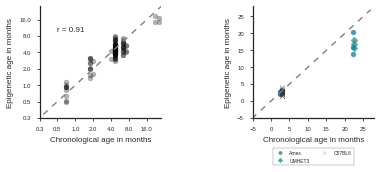

In [22]:
loc1 = (0.999,-0.25)
loc2 = (0.85,-0.25)
#loc3 = (1,-0.15)
f,axes = plt.subplots(1,2,figsize=(6,2))
make_cv_figplot_log(cv_results,axes[0],loc1,markersize=25,range_end_treat=28)
make_test_plot(plotdf,axes[1],loc2,markersize=25,range_end_treat=28)
#make_residuals_plot(normal_plotdf,'treatment',sns.color_palette('Paired',n_colors=normal_plotdf['mouse'].unique().shape[0]),loc3,axes[2],norm_mouse_order,swarmsize=4,split=False)
f.subplots_adjust(wspace=0.75)
#f.savefig('plots/LogAge_ControlElasticNetPerformance_noRes_logCV.pdf',dpi=700,bbox_inches='tight')
plt.show()
plt.close()

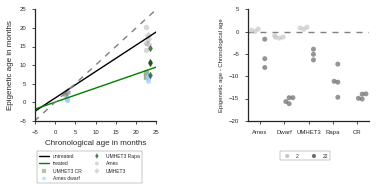

In [23]:
f,axes = plt.subplots(1,2,figsize=(6,2))
loc2 = (0.9,-0.25)
loc3 = (0.7,-0.25)
#make_cv_figplot(cv_results_dict[cat_base],tt_plotdf,axes[0],loc1,range_end_treat=25)
make_interventions_plot(plotdf,axes[0],loc2,range_end_treat=25,offset_ages_amt=0.5,markersize=25,rescale=False)
plotdf_sub = plotdf[plotdf['mouse2']!='C57BL6']
make_residuals_plot(plotdf_sub,'mouse2',sns.color_palette('Greys',n_colors=2),loc3,axes[1],[2,22],swarmsize=5,split=True,despine_bottom=False,hue_col='ChronAgeMonth',n_col=2,order=['Ames','Dwarf','UMHET3','Rapa','CR'],rescaled=False)
f.subplots_adjust(hspace=0.65,wspace=0.75)
plt.show()
plt.close()

### Statistical tests

#### Statistical tests controls

In [24]:
df = plotdf
control_dfs = df.loc[(df.treatment2=='untreated') | df.Study.isin(['SRP032932'])]
controls_2m = control_dfs.loc[control_dfs.Age_month<22]
controls_22 = control_dfs.loc[control_dfs.Age_month==22]
controls_miller = control_dfs.loc[control_dfs.Study == 'Miller']
controls_ames = control_dfs.loc[control_dfs.Study == 'Ames']
controls_srp = control_dfs.loc[control_dfs.Study == 'SRP032932']
pv_2 = stats.f_oneway(*[grp['EpiAgeMonths'] for k,grp in controls_2m.groupby('Study')])[1]
pv_22 = stats.f_oneway(*[grp['EpiAgeMonths'] for k,grp in controls_22.groupby('Study')])[1]
pv_2v22 = stats.f_oneway(*[grp['EpiAgeMonths'] for k,grp in control_dfs.groupby('Age_month')])[1]
pv_miller2v22 = stats.f_oneway(*[grp['EpiAgeMonths'] for k,grp in controls_miller.groupby('Age_month')])[1]
pv_ames2v22 = stats.f_oneway(*[grp['EpiAgeMonths'] for k,grp in controls_ames.groupby('Age_month')])[1]
anova_control_bycat = [pv_2,pv_22,pv_2v22,pv_miller2v22,pv_ames2v22]
anova_control_bycat = pd.DataFrame(anova_control_bycat,index=['2m Ames/UMHET3/C57BL6','22m UMHET3 v 22m Ames','2m v 22m UMHET or Ames (ANOVA)','2m v 22m (Ames)','2m v 22m (UMHET3)'],columns=['pvalue'])

In [25]:
anova_control_bycat

,pvalue
2m Ames/UMHET3/C57BL6,6.145405e-01
22m UMHET3 v 22m Ames,9.443491e-01
2m v 22m UMHET or Ames (ANOVA),6.274232e-35
2m v 22m (Ames),3.786270e-05
2m v 22m (UMHET3),1.559034e-03


#### Statistical tests treatments

In [29]:
dict_means = {k:grp['EpiAgeMonths'].mean() for k,grp in plotdf_sub.groupby('mouse')}

In [30]:
pairings = [('2m Ames','2m Ames dwarf'),('22m Ames','22m Ames dwarf'),('22m UMHET3','22m UMHET3 Rapa'),('22m UMHET3','22m UMHET3 CR')]
ttest_df = []
for control,treatment in pairings:
    pval = stats.ttest_ind(plotdf_sub.loc[plotdf_sub.mouse==control,'RescaledEpiAges'],plotdf_sub.loc[plotdf_sub.mouse==treatment,'RescaledEpiAges'])[1]
    control_mean = dict_means[control]
    treat_mean = dict_means[treatment]
    effectsize = control_mean - treat_mean
    ttest_df.append([control,treatment,control_mean,treat_mean,effectsize,pval])
ttest_df = pd.DataFrame(ttest_df,columns=['control','treatment','control mean','treat mean','control - treatment (means)','pval'])

In [31]:
ttest_df

,control,treatment,control mean,treat mean,control - treatment (means),pval
0,2m Ames,2m Ames dwarf,2.312036,0.793394,1.518642,0.000527
1,22m Ames,22m Ames dwarf,16.731655,6.647305,10.084350,0.001555
2,22m UMHET3,22m UMHET3 Rapa,16.880221,10.893847,5.986374,0.024796
3,22m UMHET3,22m UMHET3 CR,16.880221,7.501843,9.378378,0.000037


In [32]:
#Anova for 22 month old mice
stats.f_oneway(*[grp['RescaledEpiAges'] for k,grp in plotdf_sub.loc[plotdf_sub.Age_month==22].groupby('mouse')])

F_onewayResult(statistic=19.622269048418527, pvalue=2.0404193708883521e-05)

In [33]:
#Anova for 22 month old Miller mice
stats.f_oneway(*[grp['RescaledEpiAges'] for k,grp in plotdf_sub.loc[(plotdf_sub.Age_month==22) & (plotdf_sub.Study=='Miller')].groupby('mouse')])

F_onewayResult(statistic=19.178144883706317, pvalue=0.00088700337495615838)